In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils import CENTRAL_CARBON_METABOLISM

Using license file C:\Users\riheme\gurobi.lic
Academic license - for non-commercial use only


# Loading

1. Load results

In [2]:
results = pd.read_csv('results/results.csv')
results.head()

,value_type,strain,ko,media,time_point,id,value,tag
0,flux,0,GLCptspp,Glc,0,DM_4CRSOL,4.467703e-05,Exchange
1,flux,0,GLCptspp,Glc,0,DM_5DRIB,4.627979e-05,Exchange
2,flux,0,GLCptspp,Glc,0,DM_AACALD,0.000000e+00,Exchange
3,flux,0,GLCptspp,Glc,0,DM_AMOB,4.006909e-07,Exchange
4,flux,0,GLCptspp,Glc,0,DM_MTHTHF,2.684629e-04,Exchange


2. Create masks to select data

In [3]:
flux_mask = results['value_type'] == 'flux'
dg_mask = results['value_type'] == 'delta_g'
lc_mask = results['value_type'] == 'log_concentration'

tag_mask = { tag: results['tag'] == tag for tag in CENTRAL_CARBON_METABOLISM }
ccm_mask = np.sum( [ *tag_mask.values() ], axis = 0 ).astype(bool)

wt_mask = results['ko'] == 'wt'

results[ dg_mask & (tag_mask['Pyruvate Metabolism'] | tag_mask['Citric Acid Cycle']) ].head()

,value_type,strain,ko,media,time_point,id,value,tag
2698,delta_g,0,GLCptspp,Glc,0,ACALD,-6.954046e+00,Pyruvate Metabolism
2716,delta_g,0,GLCptspp,Glc,0,ACKr,2.639211e+00,Pyruvate Metabolism
2739,delta_g,0,GLCptspp,Glc,0,ACONTa,-1.999990e-09,Citric Acid Cycle
2740,delta_g,0,GLCptspp,Glc,0,ACONTb,-9.999894e-10,Citric Acid Cycle
2742,delta_g,0,GLCptspp,Glc,0,ACS,-8.107080e+00,Pyruvate Metabolism


# Plotting

1. Plot per pathway

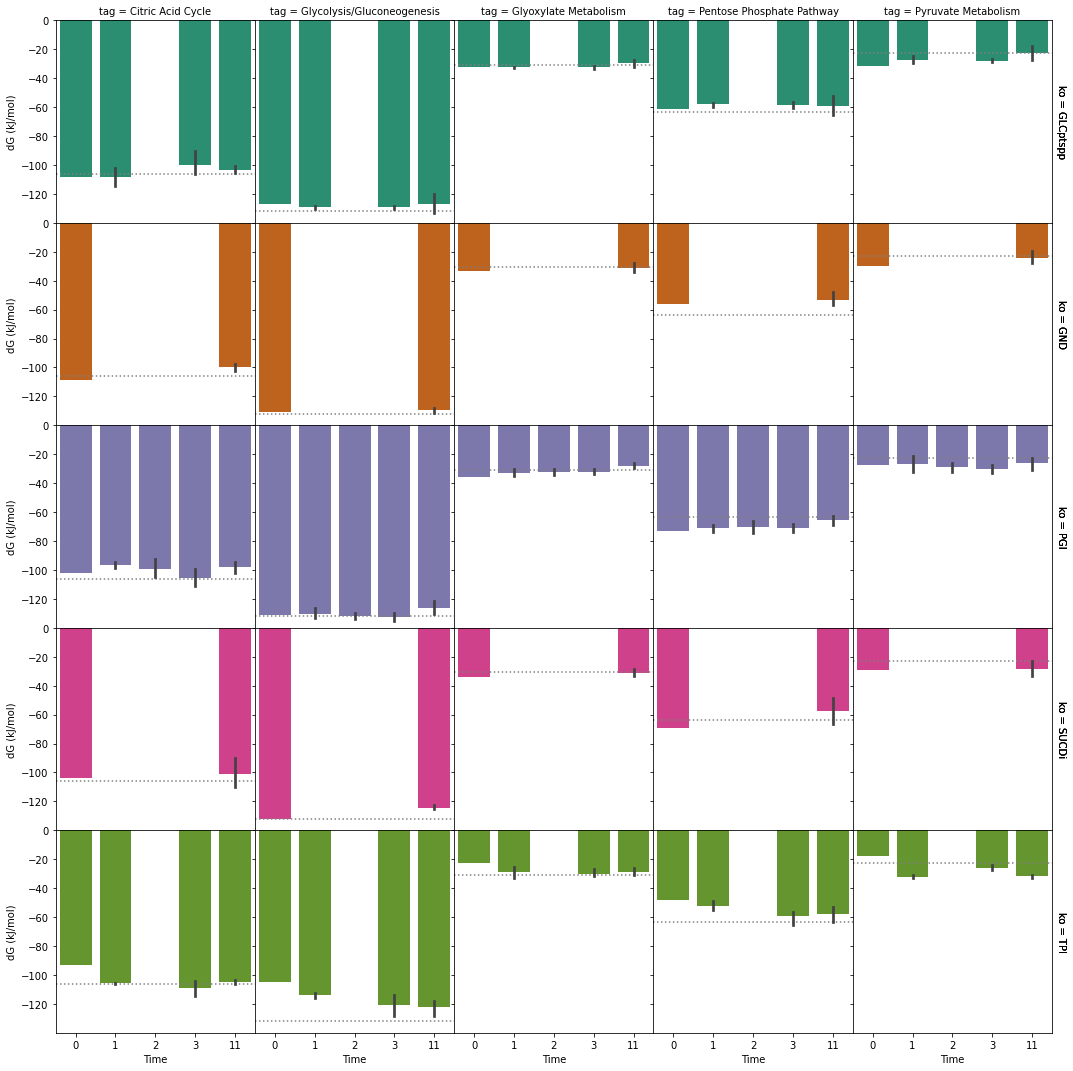

In [5]:
group = results[ dg_mask & ( ccm_mask ^ tag_mask['Oxidative Phosphorylation'] ) ].groupby([ 'strain', 'ko', 'time_point', 'tag' ]).agg(np.sum).reset_index()

def wt_line(data, **kwargs):
    wt_val = group[ (group['ko'] == 'wt') & ( group['tag'] == data['tag'].unique()[0] ) ]['value'].mean()#.groupby('time_point').agg(np.mean)['value'].values
    ax = plt.gca()
    ax.axhline( y = wt_val, ls = ':', c = '.5' )

grid = sns.FacetGrid( group[ group['ko'] != 'wt' ], col = 'tag', row = 'ko', hue = 'ko', palette = 'Dark2', margin_titles = True, despine = False, sharex = False )
grid.map_dataframe( wt_line )
grid.map( sns.barplot, 'time_point', 'value', order = [ 0, 1, 2, 3, 11 ] )

grid.fig.subplots_adjust( wspace = 0, hspace = 0 )

grid.set_titles('{col_name}')
grid.set_axis_labels('Time', 'dG (kJ/mol)')
grid.set( ylim = (-140, 0), yticks = np.arange(-140, 1e-8, 20)[1:], )

grid.fig.savefig('results/Pathways.png')

plt.show()

2. Plot per reaction

In [12]:
def wt_line(data, **kwargs):
    wt_val = results[ dg_mask & wt_mask & ( results['id'] == data['id'].unique()[0] ) ]['value'].mean()
    ax = plt.gca()
    ax.axhline( y = wt_val, ls = ':', c = '.5' )

def plot_reaction( suptitle, data ):
    grid = sns.FacetGrid( data, col = 'id', row = 'ko', hue = 'ko', palette = 'Dark2', margin_titles = True, despine = False, sharex = False )
    grid.map_dataframe( wt_line )
    grid.map( sns.barplot, 'time_point', 'value', order = [ 0, 1, 2, 3, 11 ] )
    grid.map( plt.axhline, y = 0, c = '.5' )

    grid.fig.suptitle(tag)
    grid.fig.subplots_adjust( top = 0.95, wspace = 0, hspace = 0 )

    grid.set_titles('{col_name}')
    grid.set_axis_labels('Time', 'dG (kJ/mol)')
    
    grid.fig.savefig(f'results/{tag.replace("/", "-")}.png')

    plt.show()

## Glyoxylate metabolism

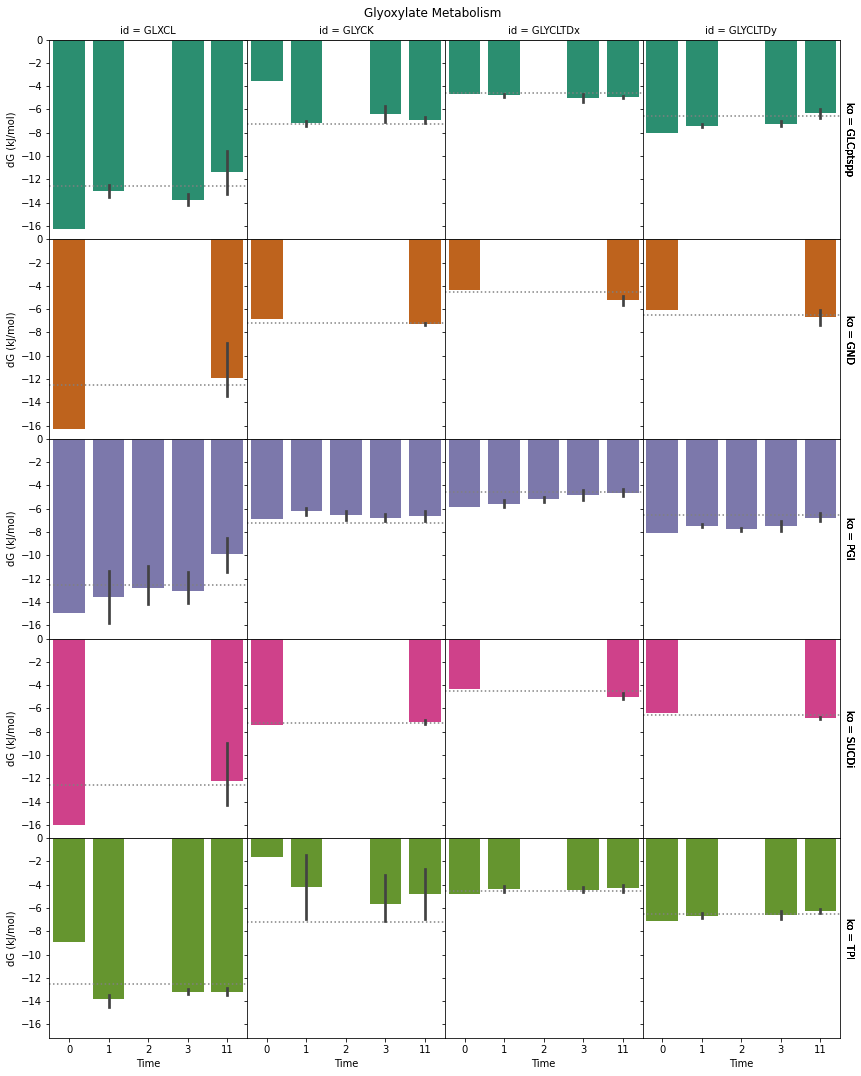

In [7]:
tag = 'Glyoxylate Metabolism'

plot_reaction( tag, results[ dg_mask & tag_mask[tag] & ~wt_mask ] )

## TCA cycle

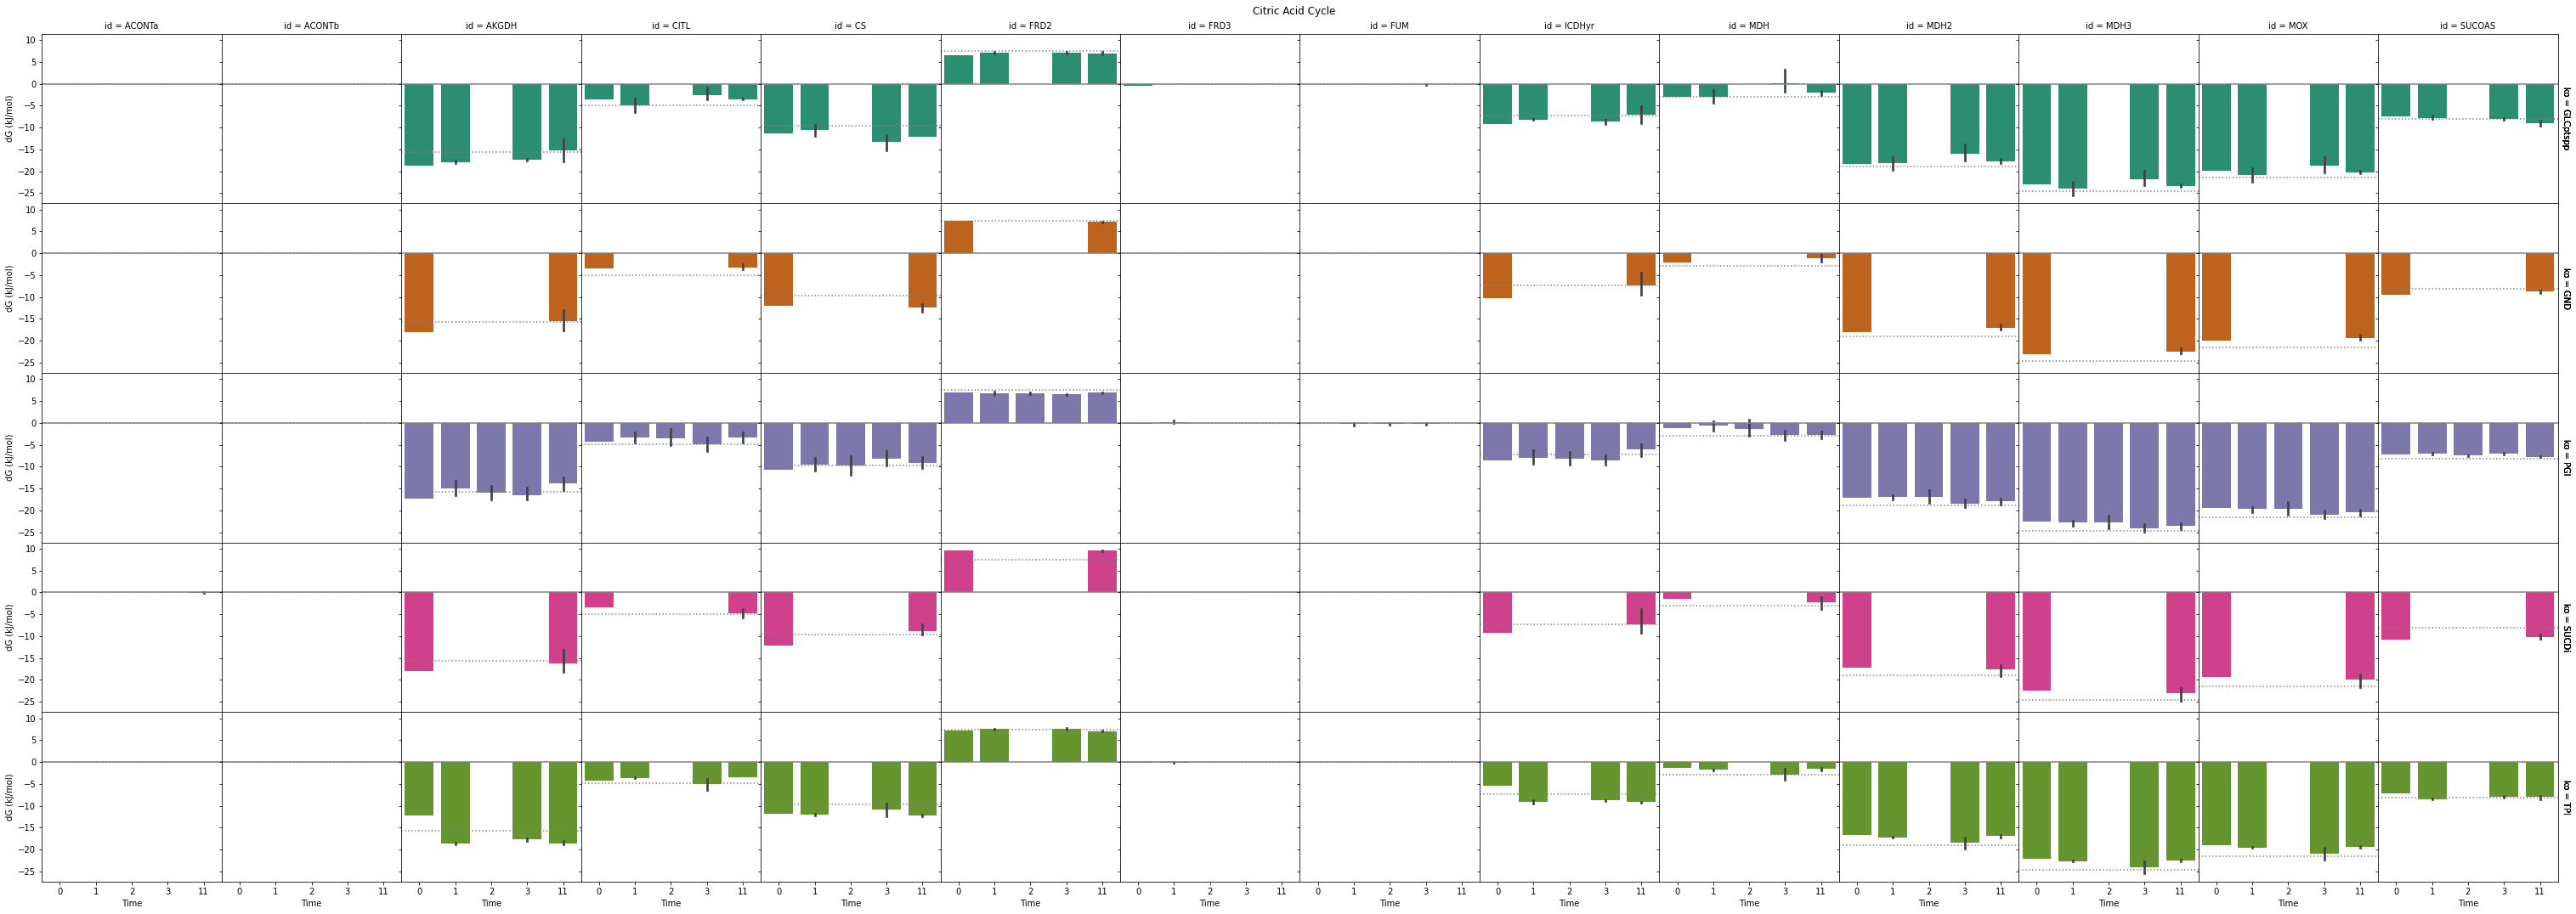

In [8]:
tag = 'Citric Acid Cycle'

plot_reaction( tag, results[ dg_mask & tag_mask[tag] & ~wt_mask ] )

## PPP

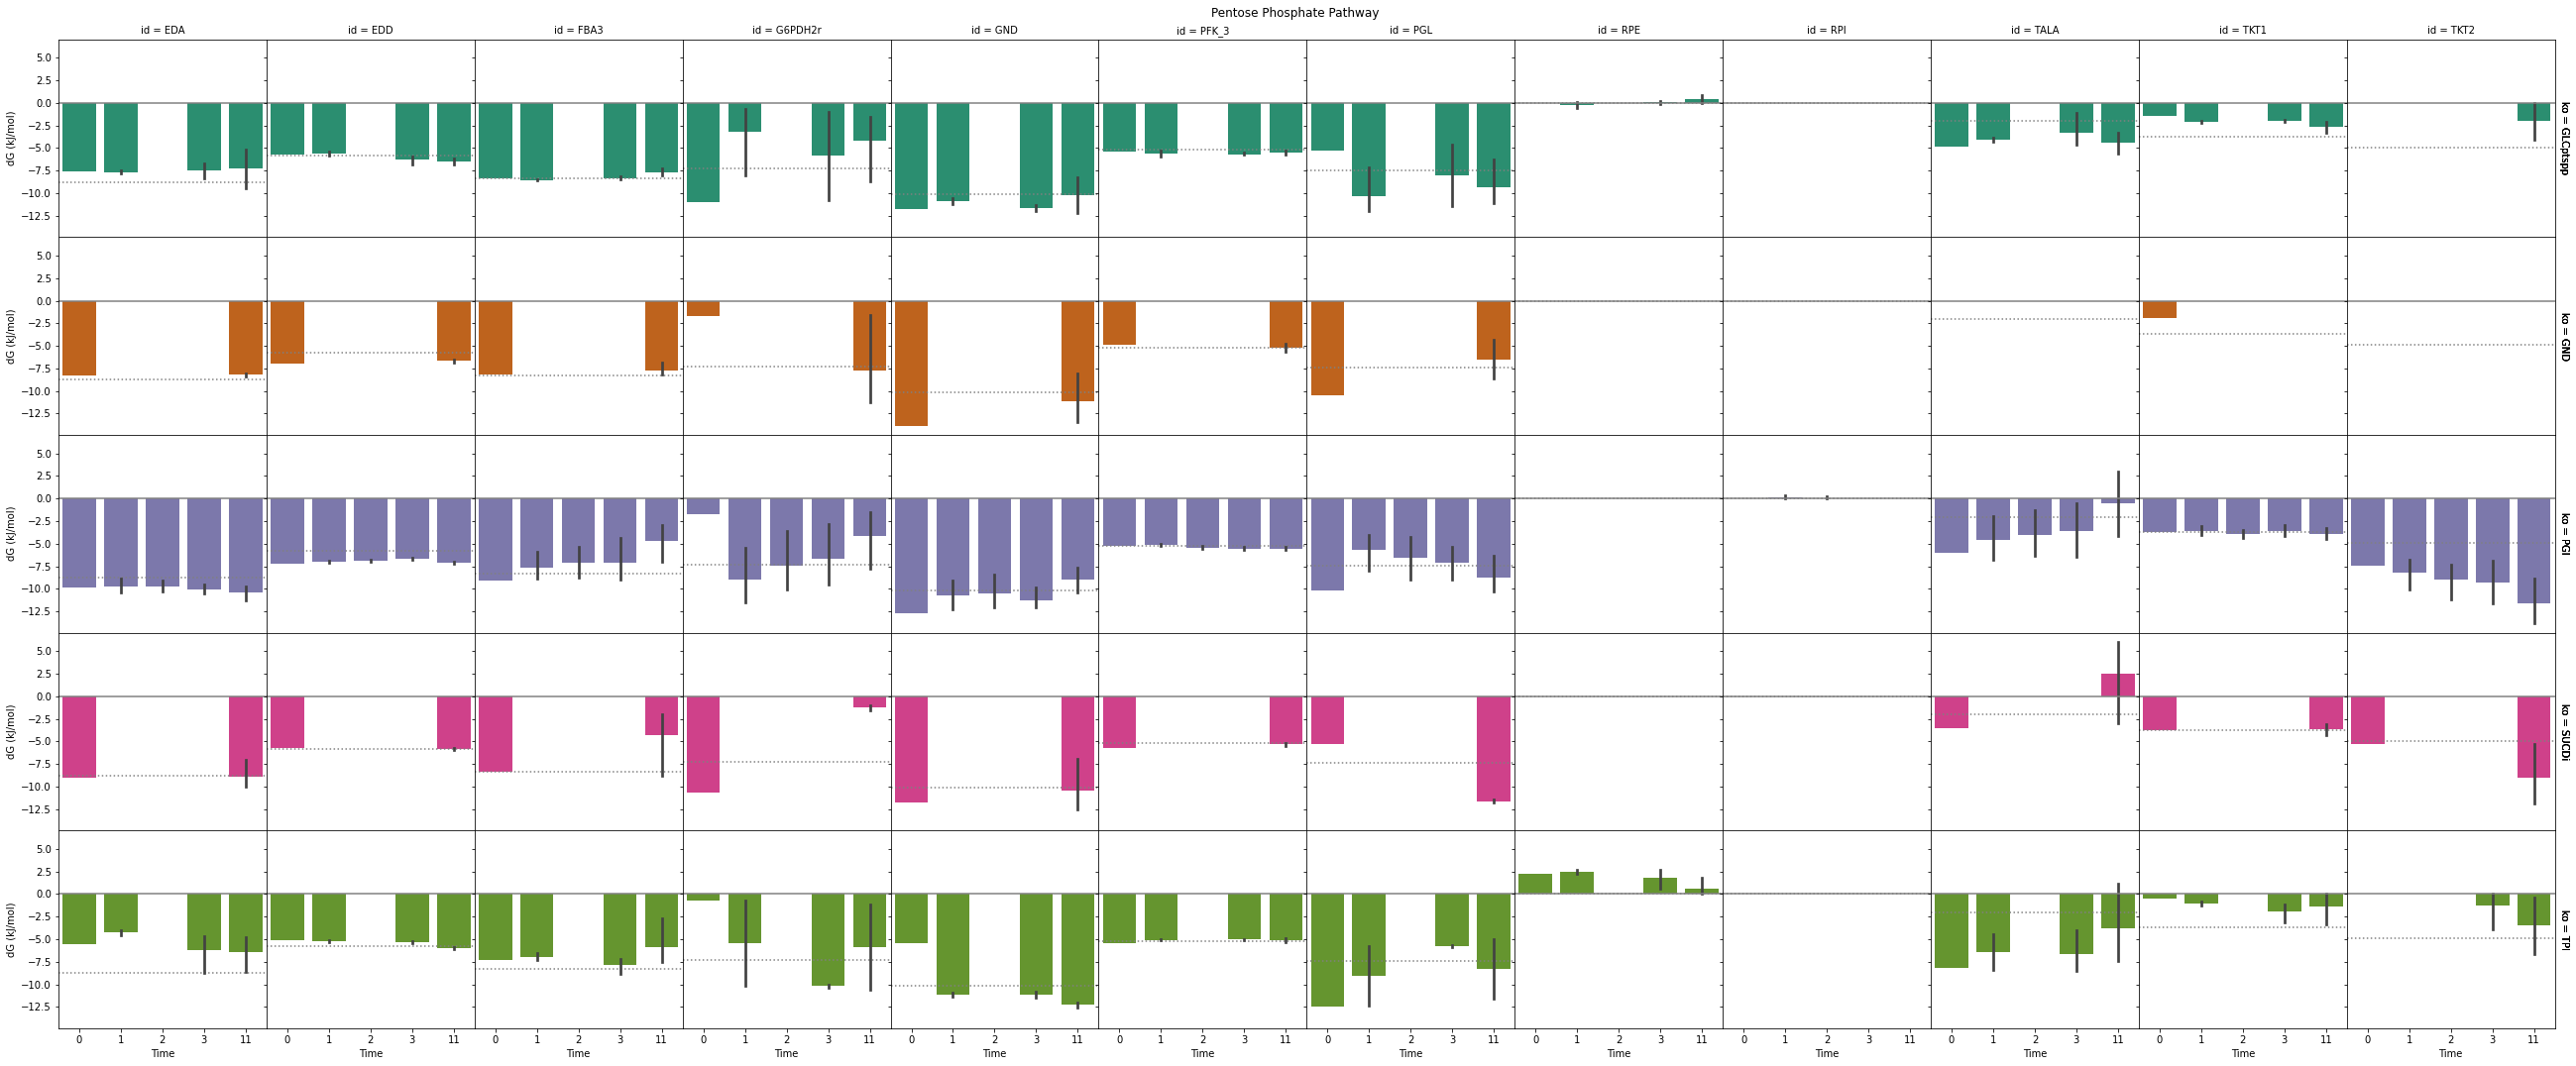

In [9]:
tag = 'Pentose Phosphate Pathway'

plot_reaction( tag, results[ dg_mask & tag_mask[tag] & ~wt_mask ] )

## Pyruvate metabolism

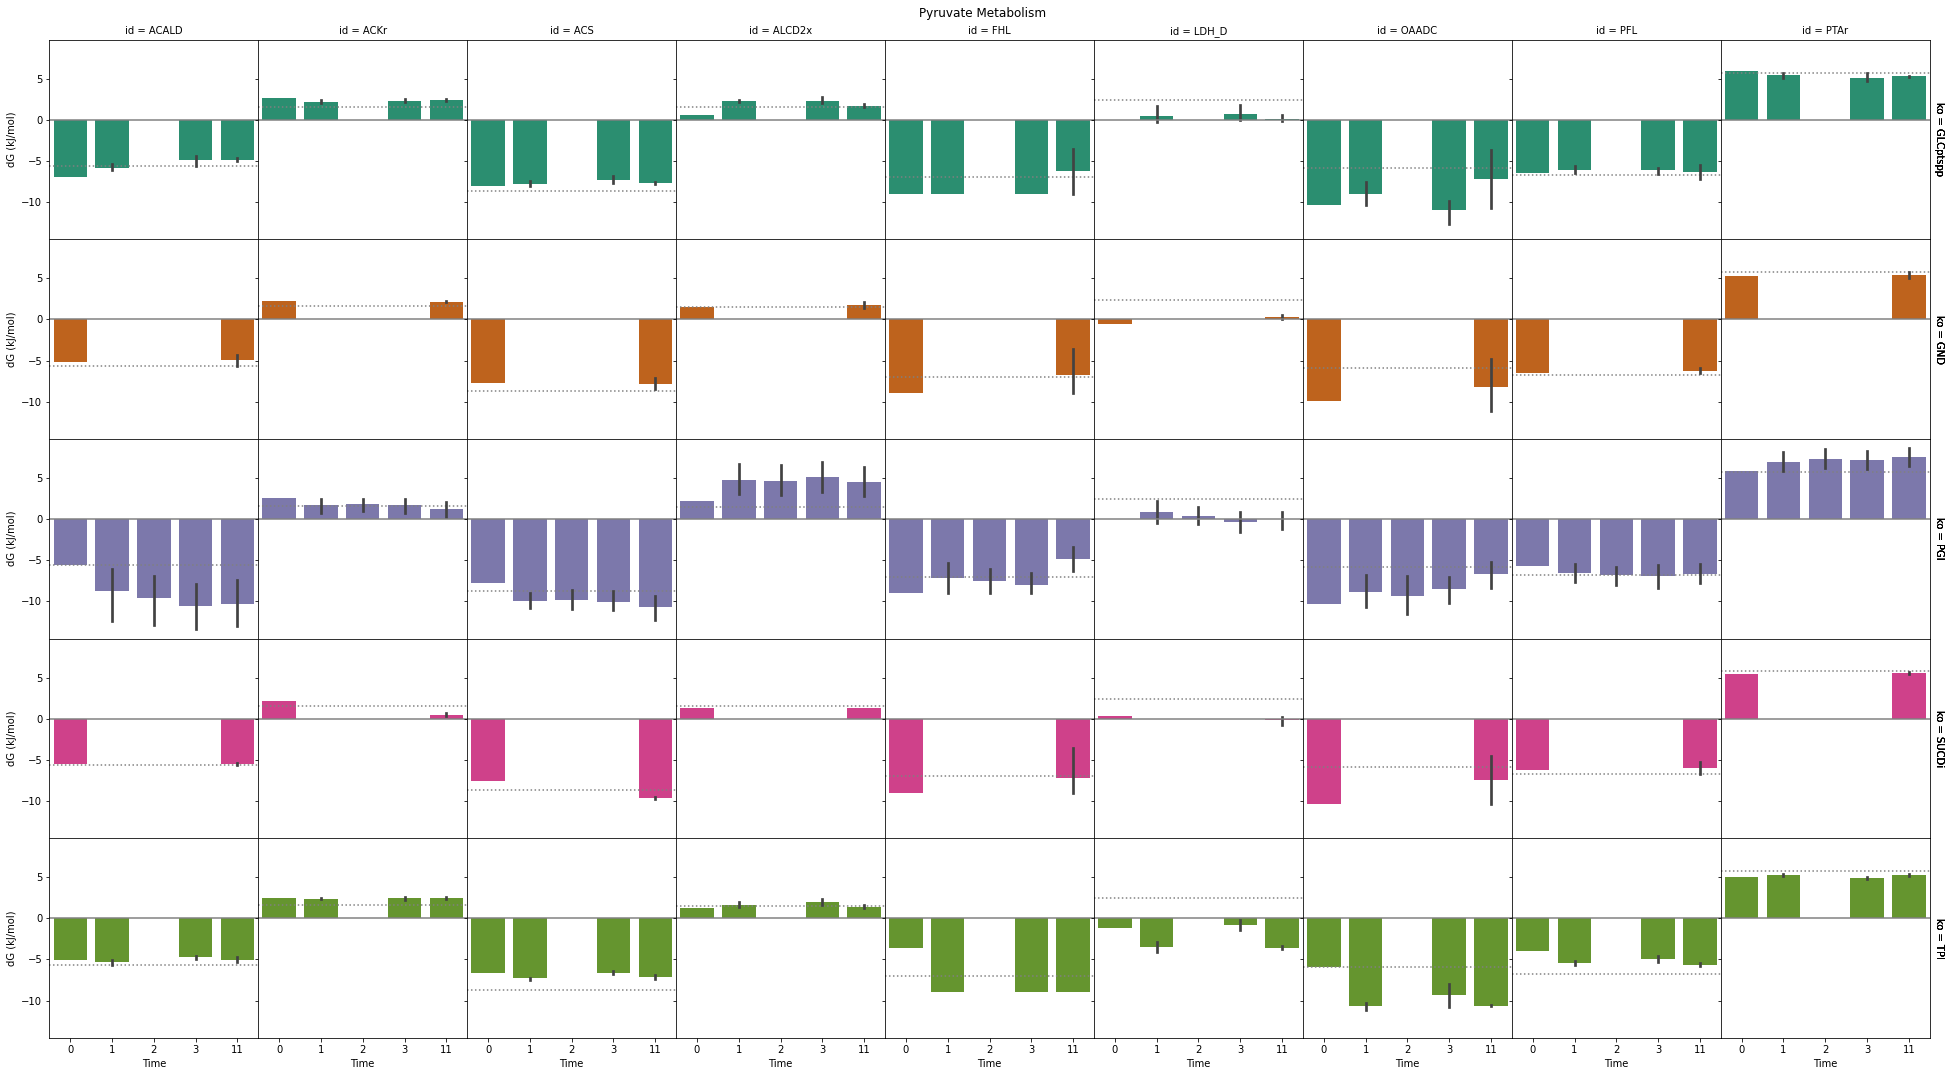

In [10]:
tag = 'Pyruvate Metabolism'

plot_reaction( tag, results[ dg_mask & tag_mask[tag] & ~wt_mask ] )

## Oxidative Phosphorylation

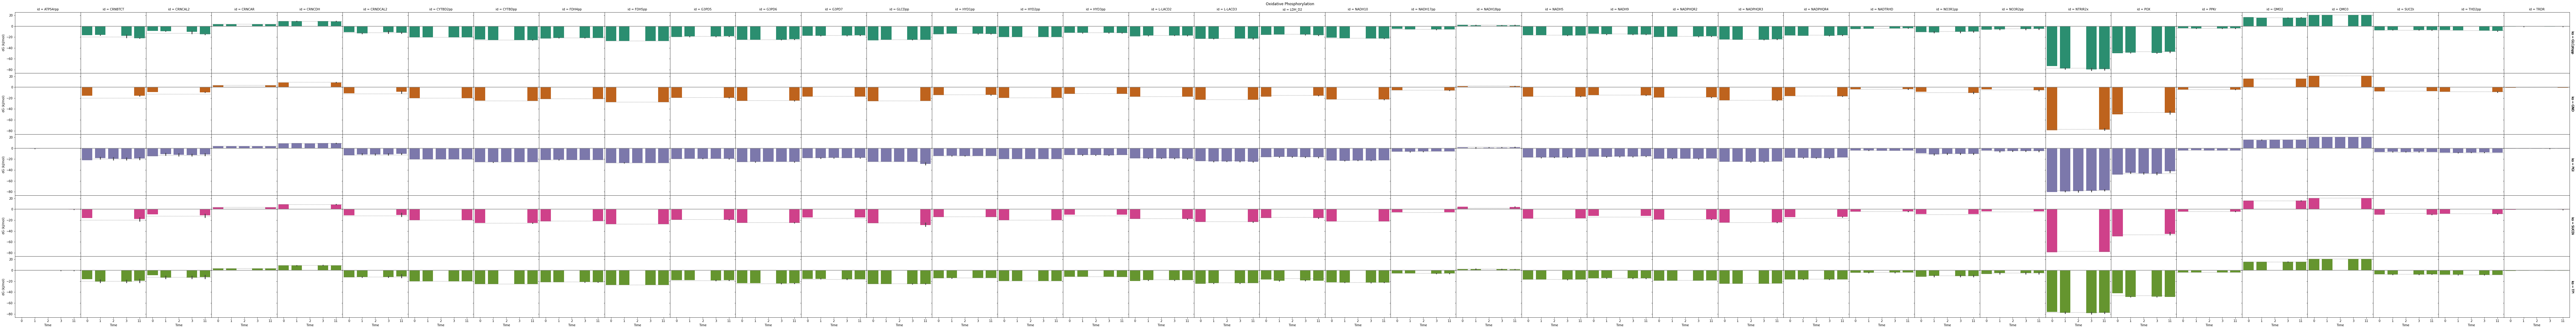

In [11]:
tag = 'Oxidative Phosphorylation'

plot_reaction( tag, results[ dg_mask & tag_mask[tag] & ~wt_mask ] )

## Glycolysis & Gluconeogenesis

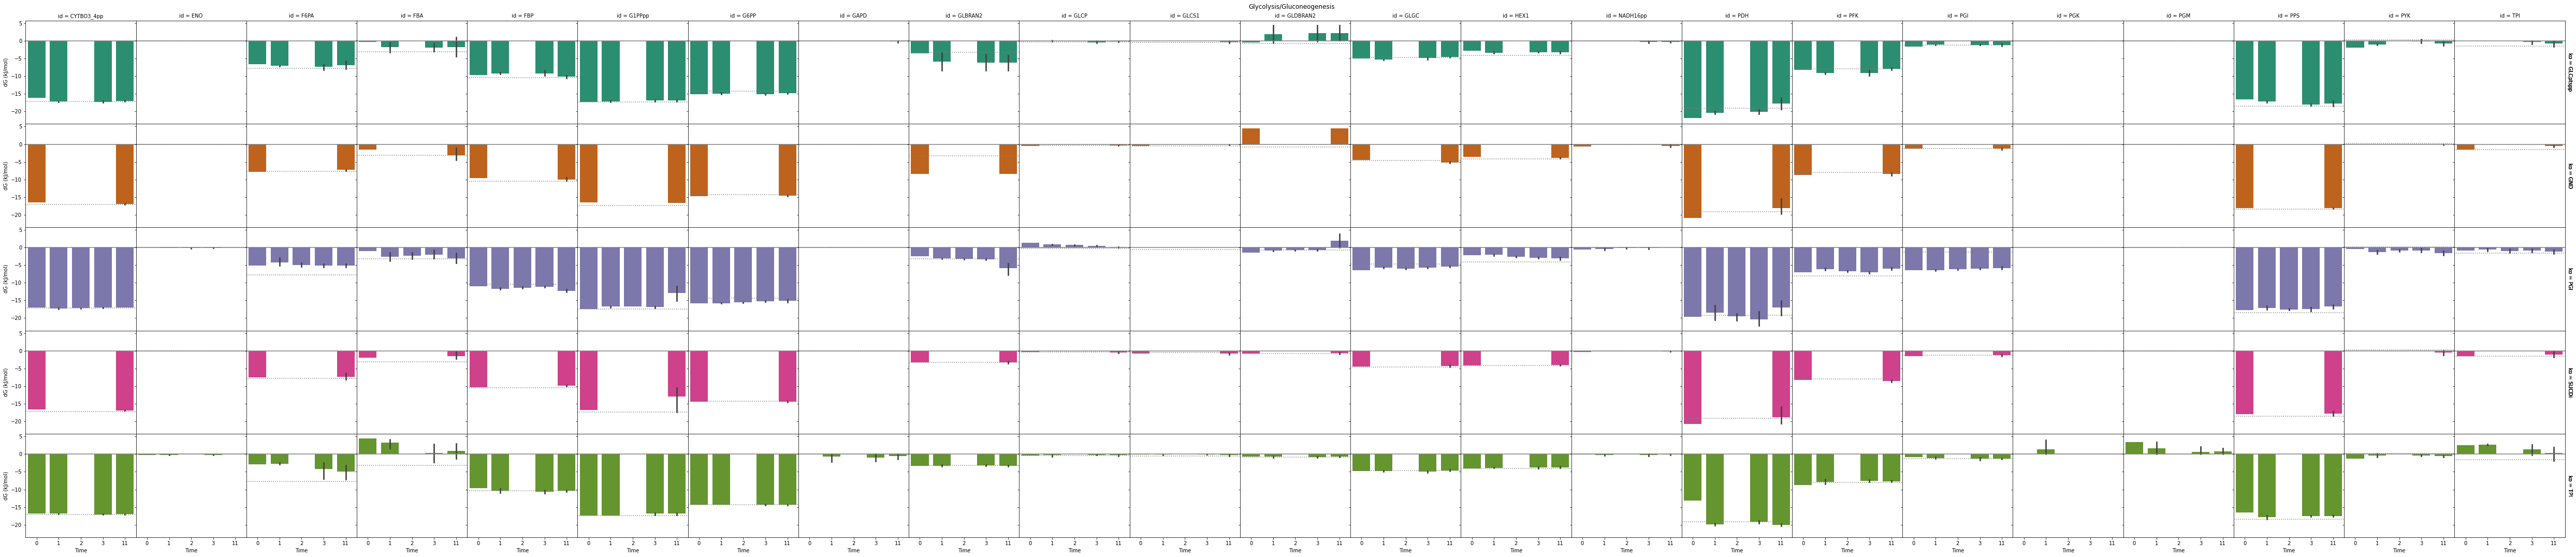

In [13]:
tag = 'Glycolysis/Gluconeogenesis'

plot_reaction( tag, results[ dg_mask & tag_mask[tag] & ~wt_mask ] )